# 4-5 Entrenamiento de Modelos y Evaluación de Resultados

In [84]:
# Procesamiento de Datos
import numpy as np
import pandas as pd
import re

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

# General
from functools import partial
import pickle

# Geográficas
from geopy.geocoders import Nominatim
import folium
from branca.element import Figure
from folium import plugins

# Balanceo del dataset
import imblearn
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Sklearn transformaciones y modelos
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
# import xgboost as xgb
from sklearn import metrics
from sklearn.pipeline import Pipeline


## Carga de Dataset y Transformadores

In [2]:
X_train = pd.read_csv("X_train.csv")
X_train_wdm = pd.read_csv("X_train_wdm.csv")
X_train_wdc = pd.read_csv("X_train_wdc.csv")
X_train_wdn = pd.read_csv("X_train_wdn.csv")

with open('output.pkl', 'rb') as f:
    output = pickle.load(f)

y_train = output['normal']
y_train_wdn = output['windir_nans']

In [3]:
X_train_wdc.shape, y_train.shape

((112339, 136), (112339,))

In [4]:
X_train_wdn.shape, y_train_wdn.shape

((98901, 96), (98901,))

In [5]:
with open('imputers.pkl', 'rb') as f:
    imputers = pickle.load(f)
    
with open('encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)

with open('scalers.pkl', 'rb') as f:
    scalers = pickle.load(f)

C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator BayesianRidge from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator IterativeImputer from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\Lautaro\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid re

In [149]:
with open('clusters.pkl', 'rb') as f:
    clusters = pickle.load(f)

## Entrenamiento de Modelos

A continuación, vamos a probar distintos modelos para el dataset sin balancear y balanceado, con distintas combinaciones de features, para los distintos datasets y estandarización cuando sea necesario. No se realizará un ajuste de los hiperparámetros porque escapa el alcance del trabajo, por lo que se deja como trabajo futuro.

### Dataset sin balancear

#### Dataset (1): imputación por moda

En todos los casos vamos a utilizar como métrica F1, la cual suele ser más frecuente para problemas de clasificación binaria con datasets imbalanceados como es éste caso.

In [6]:
X_train_wdm.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Day', 'RainToday_enc', 'WGD_deg_sin',
       'WGD_deg_cos', 'WD9_deg_sin', 'WD9_deg_cos', 'WD3_deg_sin',
       'WD3_deg_cos', '2007.0', '2008.0', '2009.0', '2010.0', '2011.0',
       '2012.0', '2013.0', '2014.0', '2015.0', '2016.0', '2017.0', 'Q1', 'Q2',
       'Q3', 'Q4', 'Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
       'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre',
       'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', 'Island', 'dist2coast',
       'Cluster_hd_-1', 'Cluster_hd_0', 'Cluster_hd_1', 'Cluster_hd_2',
       'Cluster_hd_3', 'Cluster_hd_4', 'Cluster_hd_5', 'Cluster_hd_6',
       'Cluster_hd_7', 'Cluster_ac_0', 'Cluster_ac_1', 'Cluster_ac_2',
       'Cluster_ac_3', 'Cluster_ac_4', 'Cluster_ac_5', 

Features a utilizar por cluster de ubicación:

1. Tiempo: mejores años y dia seno y coseno.
2. Tiempo: mejores años, meses trimestrales, día sin transformar.
3. Tiempo: mejores años, meses OHE, día sin transformar.
4. Tiempo: mejores años, meses seno y coseno, días sin transformar.

Vamos a dividir el análisis en modelos que necesitan estandarizado y los que no:

##### 1.1 Cluster HDBSCAN

In [7]:
modelos_std = [LogisticRegression(max_iter=1000), KNeighborsClassifier(n_neighbors=3)] 
modelos_tree = [RandomForestClassifier(max_depth=12, random_state=0, class_weight='balanced'), 
               DecisionTreeClassifier(max_depth=16, max_features="sqrt"), AdaBoostClassifier()]

In [8]:
results_wdm = []

In [9]:
features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Day', 'RainToday_enc', 'WGD_deg_sin',
       'WGD_deg_cos', 'WD9_deg_sin', 'WD9_deg_cos', 'WD3_deg_sin',
       'WD3_deg_cos', '2007.0', '2010.0', '2011.0',
       '2012.0', '2015.0', '2016.0', 'Day_sin', 'Day_cos', 'Island', 'dist2coast',
       'Cluster_hd_-1', 'Cluster_hd_0', 'Cluster_hd_1', 'Cluster_hd_2',
       'Cluster_hd_3', 'Cluster_hd_4', 'Cluster_hd_5', 'Cluster_hd_6',
       'Cluster_hd_7']

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
results=[]

for model in modelos_std:
    pipeline = Pipeline(steps=[
        ( 'standardscaler', StandardScaler()), 
        ( 'model' , model)
    ])
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
    scores = cross_val_score(pipeline, X_train_wdm[features], y_train, scoring = 'f1' , cv=cv, n_jobs=-1)    
    results.append(scores)
    print("Finalizado modelo: {}".format(model))

Finalizado modelo: LogisticRegression(max_iter=1000)
Finalizado modelo: KNeighborsClassifier(n_neighbors=3)


Text(0, 0.5, 'F1')

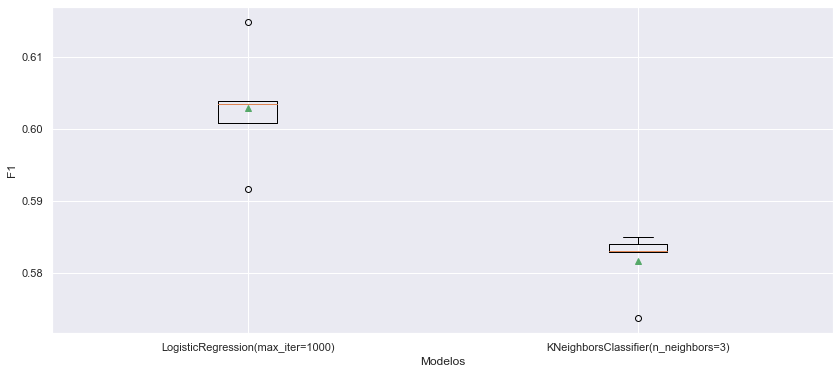

In [12]:
fig,axes = plt.subplots(1,figsize=(14,6))

axes.boxplot(results, labels=
    [x or "None" for x in modelos_std], showmeans=True)

axes.set_xlabel("Modelos")
axes.set_ylabel("F1")

In [13]:
results_tree=[]

for model in modelos_tree:
    pipeline = Pipeline(steps=[
        ( 'model' , model)
    ])
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
    scores = cross_val_score(pipeline, X_train_wdm[features], y_train, scoring = 'f1' , cv=cv, n_jobs=-1)    
    results_tree.append(scores)
    print("Finalizado modelo: {}".format(model))

Finalizado modelo: RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=0)
Finalizado modelo: DecisionTreeClassifier(max_depth=16, max_features='sqrt')
Finalizado modelo: AdaBoostClassifier()


Text(0, 0.5, 'F1')

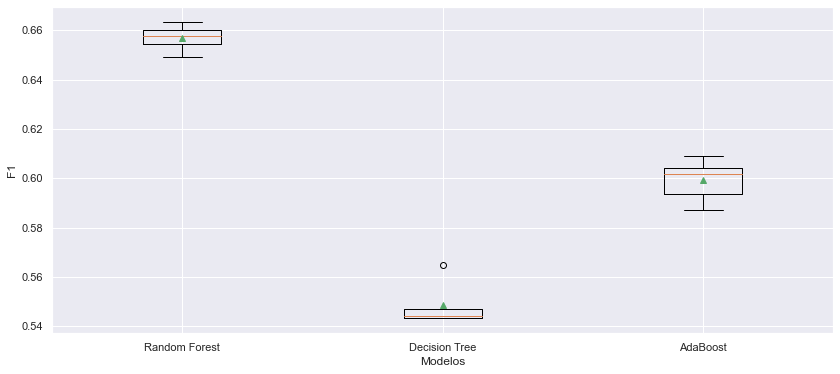

In [14]:
fig,axes = plt.subplots(1,figsize=(14,6))

labels = ['Random Forest', 'Decision Tree', 'AdaBoost']

axes.boxplot(results_tree, labels = labels, showmeans=True)

axes.set_xlabel("Modelos")
axes.set_ylabel("F1")

In [15]:
results_wdm.append({'Modelos_std': np.mean(results, axis=1), 'Modelos_tree': np.mean(results_tree, axis=1)})

##### 1.2 Cluster HDBSCAN

In [16]:
features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Day', 'RainToday_enc', 'WGD_deg_sin',
       'WGD_deg_cos', 'WD9_deg_sin', 'WD9_deg_cos', 'WD3_deg_sin',
       'WD3_deg_cos', '2007.0', '2010.0', '2011.0',
       '2012.0', '2015.0', '2016.0', 'Q1', 'Q2',
       'Q3', 'Q4', 'Island', 'dist2coast', 'Day',
       'Cluster_hd_-1', 'Cluster_hd_0', 'Cluster_hd_1', 'Cluster_hd_2',
       'Cluster_hd_3', 'Cluster_hd_4', 'Cluster_hd_5', 'Cluster_hd_6',
       'Cluster_hd_7']

In [17]:
def kfold_model_evaluation(X_train, y_train, models, info, metric):
    results = []
    
    for model in models:
        if info=="std":
            pipeline = Pipeline(steps=[
                ( 'standardscaler', StandardScaler()), 
                ( 'model' , model)
            ])
        else:
            pipeline = Pipeline(steps=[
                ( 'model' , model)
            ])
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
        scores = cross_val_score(pipeline, X_train, y_train, scoring = metric , cv=cv, n_jobs=-1)    
        results.append(scores)
        print("Finalizado modelo: {}".format(model))
    return results

In [18]:
results=[]
results_tree = []

results = kfold_model_evaluation(X_train_wdm[features], y_train, modelos_std, "std", 'f1')
results_tree = kfold_model_evaluation(X_train_wdm[features], y_train, modelos_tree, None, 'f1')

Finalizado modelo: LogisticRegression(max_iter=1000)
Finalizado modelo: KNeighborsClassifier(n_neighbors=3)
Finalizado modelo: RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=0)
Finalizado modelo: DecisionTreeClassifier(max_depth=16, max_features='sqrt')
Finalizado modelo: AdaBoostClassifier()


Text(0, 0.5, 'F1')

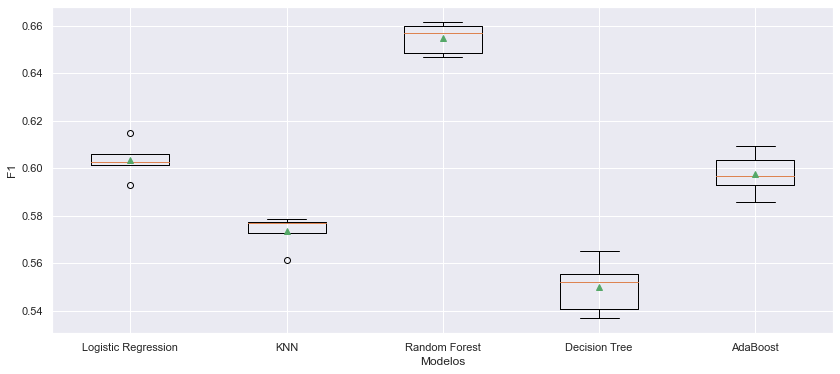

In [19]:
fig,axes = plt.subplots(1,figsize=(14,6))

labels_std = ['Logistic Regression', 'KNN']
labels_tree = ['Random Forest', 'Decision Tree', 'AdaBoost']

axes.boxplot(np.vstack((results, results_tree)).T, labels = labels_std+labels_tree, showmeans=True)

axes.set_xlabel("Modelos")
axes.set_ylabel("F1")

In [20]:
results_wdm.append({'Modelos_std': np.mean(results, axis=1), 'Modelos_tree': np.mean(results_tree, axis=1)})

##### 1.3 Cluster HDBSCAN

In [21]:
features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Day', 'RainToday_enc', 'WGD_deg_sin',
       'WGD_deg_cos', 'WD9_deg_sin', 'WD9_deg_cos', 'WD3_deg_sin',
       'WD3_deg_cos', '2007.0', '2010.0', '2011.0', '2012.0', '2015.0', '2016.0', 'Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
       'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre', 'Island', 'dist2coast', 'Day',
       'Cluster_hd_-1', 'Cluster_hd_0', 'Cluster_hd_1', 'Cluster_hd_2',
       'Cluster_hd_3', 'Cluster_hd_4', 'Cluster_hd_5', 'Cluster_hd_6',
       'Cluster_hd_7']

In [22]:
results=[]
results_tree = []

results = kfold_model_evaluation(X_train_wdm[features], y_train, modelos_std, "std", 'f1')
results_tree = kfold_model_evaluation(X_train_wdm[features], y_train, modelos_tree, None, 'f1')

Finalizado modelo: LogisticRegression(max_iter=1000)
Finalizado modelo: KNeighborsClassifier(n_neighbors=3)
Finalizado modelo: RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=0)
Finalizado modelo: DecisionTreeClassifier(max_depth=16, max_features='sqrt')
Finalizado modelo: AdaBoostClassifier()


Text(0, 0.5, 'F1')

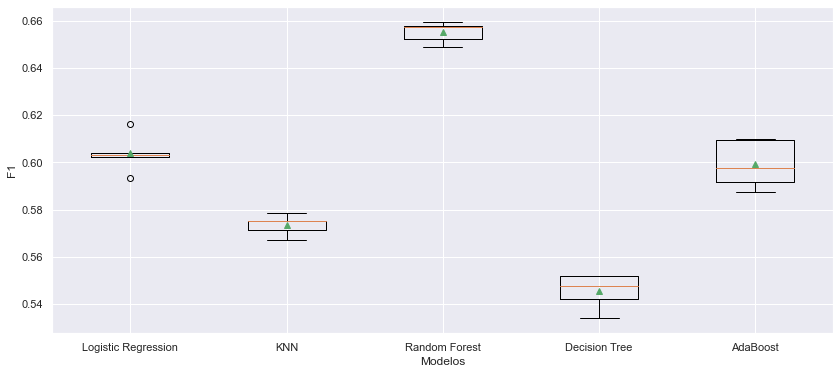

In [23]:
fig,axes = plt.subplots(1,figsize=(14,6))

labels_std = ['Logistic Regression', 'KNN']
labels_tree = ['Random Forest', 'Decision Tree', 'AdaBoost']

axes.boxplot(np.vstack((results, results_tree)).T, labels = labels_std+labels_tree, showmeans=True)

axes.set_xlabel("Modelos")
axes.set_ylabel("F1")

In [24]:
results_wdm.append({'Modelos_std': np.mean(results, axis=1), 'Modelos_tree': np.mean(results_tree, axis=1)})

##### 1.4 Cluster HDBSCAN

In [25]:
features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Day', 'RainToday_enc', 'WGD_deg_sin',
       'WGD_deg_cos', 'WD9_deg_sin', 'WD9_deg_cos', 'WD3_deg_sin',
       'WD3_deg_cos', '2007.0', '2010.0', '2011.0', '2012.0', '2015.0', '2016.0',
       'Month_sin', 'Month_cos' , 'Island', 'dist2coast', 'Day',
       'Cluster_hd_-1', 'Cluster_hd_0', 'Cluster_hd_1', 'Cluster_hd_2',
       'Cluster_hd_3', 'Cluster_hd_4', 'Cluster_hd_5', 'Cluster_hd_6',
       'Cluster_hd_7']

In [26]:
results=[]
results_tree = []

results = kfold_model_evaluation(X_train_wdm[features], y_train, modelos_std, "std", 'f1')
results_tree = kfold_model_evaluation(X_train_wdm[features], y_train, modelos_tree, None, 'f1')

Finalizado modelo: LogisticRegression(max_iter=1000)
Finalizado modelo: KNeighborsClassifier(n_neighbors=3)
Finalizado modelo: RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=0)
Finalizado modelo: DecisionTreeClassifier(max_depth=16, max_features='sqrt')
Finalizado modelo: AdaBoostClassifier()


Text(0, 0.5, 'F1')

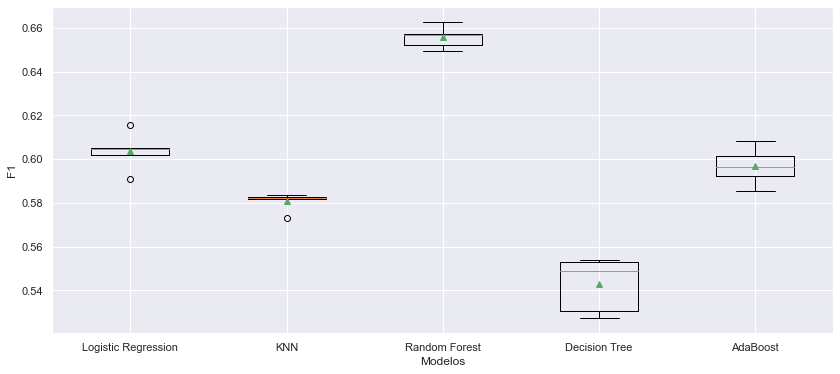

In [27]:
fig,axes = plt.subplots(1,figsize=(14,6))

labels_std = ['Logistic Regression', 'KNN']
labels_tree = ['Random Forest', 'Decision Tree', 'AdaBoost']

axes.boxplot(np.vstack((results, results_tree)).T, labels = labels_std+labels_tree, showmeans=True)

axes.set_xlabel("Modelos")
axes.set_ylabel("F1")

In [28]:
results_wdm.append({'Modelos_std': np.mean(results, axis=1), 'Modelos_tree': np.mean(results_tree, axis=1)})

Se puede observar como, en general, los mejores resultados se obtienen para Regresión Logística y Random Forest. Ámbos mostraron mejores resultados para la codificación cíclica del día-mes y el resto de los modelos basados en árboles o ensambles experimentaron mejores resultados con las codificaciones por OHE. Es llamativo el bajo desempeño de los árboles de decisión.

Dado que la primera configuración fue la más exitosa, se dejará fija esa combinación de features temporales y se variará el cluster de ubicación a utilizar para estudiar ese efecto:

##### 2. 1 Cluster Agglomerative Clustering

In [29]:
features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Day', 'RainToday_enc', 'WGD_deg_sin',
       'WGD_deg_cos', 'WD9_deg_sin', 'WD9_deg_cos', 'WD3_deg_sin',
       'WD3_deg_cos', '2007.0', '2010.0', '2011.0',
       '2012.0', '2015.0', '2016.0', 'Day_sin', 'Day_cos', 'Island', 'dist2coast',
        'Cluster_ac_0', 'Cluster_ac_1', 'Cluster_ac_2',
       'Cluster_ac_3', 'Cluster_ac_4', 'Cluster_ac_5', 'Cluster_ac_6']

In [30]:
results=[]
results_tree = []

results = kfold_model_evaluation(X_train_wdm[features], y_train, modelos_std, "std", 'f1')
results_tree = kfold_model_evaluation(X_train_wdm[features], y_train, modelos_tree, None, 'f1')

Finalizado modelo: LogisticRegression(max_iter=1000)
Finalizado modelo: KNeighborsClassifier(n_neighbors=3)
Finalizado modelo: RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=0)
Finalizado modelo: DecisionTreeClassifier(max_depth=16, max_features='sqrt')
Finalizado modelo: AdaBoostClassifier()


Text(0, 0.5, 'F1')

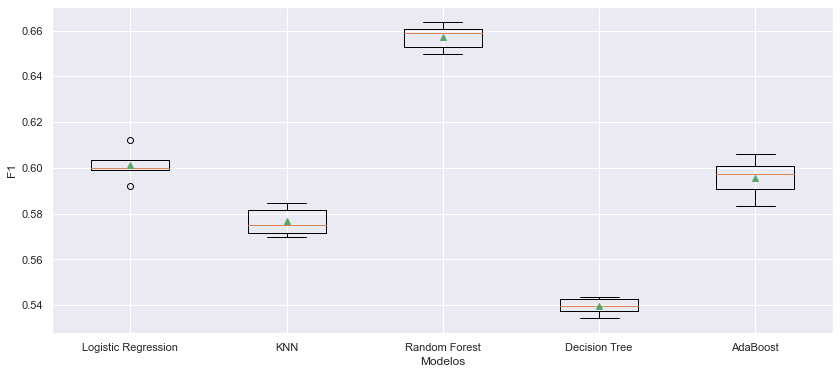

In [31]:
fig,axes = plt.subplots(1,figsize=(14,6))

labels_std = ['Logistic Regression', 'KNN']
labels_tree = ['Random Forest', 'Decision Tree', 'AdaBoost']

axes.boxplot(np.vstack((results, results_tree)).T, labels = labels_std+labels_tree, showmeans=True)

axes.set_xlabel("Modelos")
axes.set_ylabel("F1")

In [32]:
results_wdm.append({'Modelos_std': np.mean(results, axis=1), 'Modelos_tree': np.mean(results_tree, axis=1)})

##### 3. 1 OPTICS Clustering

In [33]:
features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Day', 'RainToday_enc', 'WGD_deg_sin',
       'WGD_deg_cos', 'WD9_deg_sin', 'WD9_deg_cos', 'WD3_deg_sin',
       'WD3_deg_cos', '2007.0', '2010.0', '2011.0',
       '2012.0', '2015.0', '2016.0', 'Day_sin', 'Day_cos', 'Island', 'dist2coast',
        'Cluster_opt_1', 'Cluster_opt_2',
       'Cluster_opt_3', 'Cluster_opt_4', 'Cluster_opt_5', 'Cluster_opt_6',
       'Cluster_opt_7', 'Cluster_opt_8', 'Cluster_opt_9', 'Cluster_opt_10',
       'Cluster_opt_11', 'Cluster_opt_12', 'Cluster_opt_13', 'Cluster_opt_14',
       'Cluster_opt_15', 'Cluster_opt_16']

In [34]:
results=[]
results_tree = []

results = kfold_model_evaluation(X_train_wdm[features], y_train, modelos_std, "std", 'f1')
results_tree = kfold_model_evaluation(X_train_wdm[features], y_train, modelos_tree, None, 'f1')

Finalizado modelo: LogisticRegression(max_iter=1000)
Finalizado modelo: KNeighborsClassifier(n_neighbors=3)
Finalizado modelo: RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=0)
Finalizado modelo: DecisionTreeClassifier(max_depth=16, max_features='sqrt')
Finalizado modelo: AdaBoostClassifier()


Text(0, 0.5, 'F1')

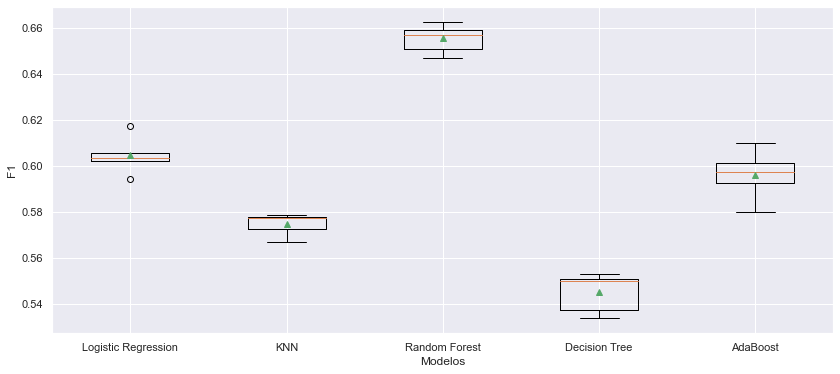

In [35]:
fig,axes = plt.subplots(1,figsize=(14,6))

labels_std = ['Logistic Regression', 'KNN']
labels_tree = ['Random Forest', 'Decision Tree', 'AdaBoost']

axes.boxplot(np.vstack((results, results_tree)).T, labels = labels_std+labels_tree, showmeans=True)

axes.set_xlabel("Modelos")
axes.set_ylabel("F1")

In [36]:
results_wdm.append({'Modelos_std': np.mean(results, axis=1), 'Modelos_tree': np.mean(results_tree, axis=1)})

In [40]:
results_hdbscan = results_wdm[0]
results_agg = results_wdm[4]
results_opt = results_wdm[5]

clusters = {'HDBSCAN':results_hdbscan, 'Agglomerative Clustering':results_agg, 'OPTICS':results_opt}

for cluster in clusters.keys():
    print("{} - Media de F1 para Regresión Logística: {:.6f}".format(cluster, clusters[cluster]['Modelos_std'][0]))
    print("{} - Media de F1 para Random Forest: {:.6f}".format(cluster, clusters[cluster]['Modelos_tree'][0]))

HDBSCAN - Media de F1 para Regresión Logística: 0.602986
HDBSCAN - Media de F1 para Random Forest: 0.656954
Agglomerative Clustering - Media de F1 para Regresión Logística: 0.601270
Agglomerative Clustering - Media de F1 para Random Forest: 0.657099
OPTICS - Media de F1 para Regresión Logística: 0.604589
OPTICS - Media de F1 para Random Forest: 0.655478


Vemos que los resultados para los tres tipos de clusters son bastante similares, donde OPTICS quizás muestra una leve mejoría en Regresión Logística respecto del resto. Siendo ese el caso, se preferirá utilizar Agglomerative Clustering que cuenta con la menor cantidad de features. Vemos que ocurre si usamos todos los clusters:

##### 4.1 Todos los Clusters

In [41]:
features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Day', 'RainToday_enc', 'WGD_deg_sin',
       'WGD_deg_cos', 'WD9_deg_sin', 'WD9_deg_cos', 'WD3_deg_sin',
       'WD3_deg_cos', '2007.0', '2010.0', '2011.0',
       '2012.0', '2015.0', '2016.0', 'Day_sin', 'Day_cos', 'Island', 'dist2coast',
       'Cluster_hd_-1', 'Cluster_hd_0', 'Cluster_hd_1', 'Cluster_hd_2',
       'Cluster_hd_3', 'Cluster_hd_4', 'Cluster_hd_5', 'Cluster_hd_6',
       'Cluster_hd_7', 'Cluster_ac_0', 'Cluster_ac_1', 'Cluster_ac_2',
       'Cluster_ac_3', 'Cluster_ac_4', 'Cluster_ac_5', 'Cluster_ac_6',
       'Cluster_opt_-1', 'Cluster_opt_0', 'Cluster_opt_1', 'Cluster_opt_2',
       'Cluster_opt_3', 'Cluster_opt_4', 'Cluster_opt_5', 'Cluster_opt_6',
       'Cluster_opt_7', 'Cluster_opt_8', 'Cluster_opt_9', 'Cluster_opt_10',
       'Cluster_opt_11', 'Cluster_opt_12', 'Cluster_opt_13', 'Cluster_opt_14',
       'Cluster_opt_15', 'Cluster_opt_16']

In [42]:
results=[]
results_tree = []

results = kfold_model_evaluation(X_train_wdm[features], y_train, modelos_std, "std", 'f1')
results_tree = kfold_model_evaluation(X_train_wdm[features], y_train, modelos_tree, None, 'f1')

Finalizado modelo: LogisticRegression(max_iter=1000)
Finalizado modelo: KNeighborsClassifier(n_neighbors=3)
Finalizado modelo: RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=0)
Finalizado modelo: DecisionTreeClassifier(max_depth=16, max_features='sqrt')
Finalizado modelo: AdaBoostClassifier()


Text(0, 0.5, 'F1')

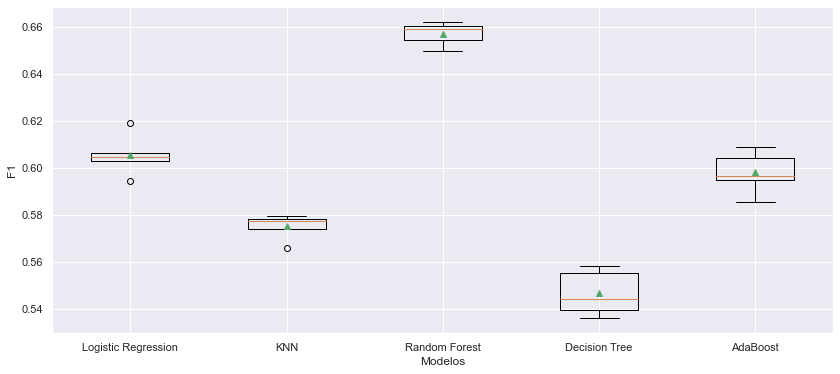

In [43]:
fig,axes = plt.subplots(1,figsize=(14,6))

labels_std = ['Logistic Regression', 'KNN']
labels_tree = ['Random Forest', 'Decision Tree', 'AdaBoost']

axes.boxplot(np.vstack((results, results_tree)).T, labels = labels_std+labels_tree, showmeans=True)

axes.set_xlabel("Modelos")
axes.set_ylabel("F1")

In [44]:
results_wdm.append({'Modelos_std': np.mean(results, axis=1), 'Modelos_tree': np.mean(results_tree, axis=1)})

In [45]:
results_total = results_wdm[6]

clusters = {'Total Clusters':results_total}

for cluster in clusters.keys():
    print("{} - Media de F1 para Regresión Logística: {:.6f}".format(cluster, clusters[cluster]['Modelos_std'][0]))
    print("{} - Media de F1 para Random Forest: {:.6f}".format(cluster, clusters[cluster]['Modelos_tree'][0]))

Total Clusters - Media de F1 para Regresión Logística: 0.605544
Total Clusters - Media de F1 para Random Forest: 0.657167


Se obtuvo una muy leve mejoría en las métricas en ámbos modelos, al contemplar el total de las features. De todos modos, no se justifica la mejora para incorporar esa gran cantidad de features. Probaremos por último utilizar Agglomerative Clustering junto a todas las features de ubicación:

##### 2.5 Agglomerative Clustering - Total Features Temporales

In [46]:
features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Day', 'RainToday_enc', 'WGD_deg_sin',
       'WGD_deg_cos', 'WD9_deg_sin', 'WD9_deg_cos', 'WD3_deg_sin',
       'WD3_deg_cos', '2007.0', '2008.0', '2009.0', '2010.0', '2011.0',
       '2012.0', '2013.0', '2014.0', '2015.0', '2016.0', '2017.0', 'Q1', 'Q2',
       'Q3', 'Q4', 'Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
       'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre',
       'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', 'Island', 'dist2coast',
       'Cluster_ac_0', 'Cluster_ac_1', 'Cluster_ac_2',
       'Cluster_ac_3', 'Cluster_ac_4', 'Cluster_ac_5', 'Cluster_ac_6']

In [47]:
results=[]
results_tree = []

results = kfold_model_evaluation(X_train_wdm[features], y_train, modelos_std, "std", 'f1')
results_tree = kfold_model_evaluation(X_train_wdm[features], y_train, modelos_tree, None, 'f1')

Finalizado modelo: LogisticRegression(max_iter=1000)
Finalizado modelo: KNeighborsClassifier(n_neighbors=3)
Finalizado modelo: RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=0)
Finalizado modelo: DecisionTreeClassifier(max_depth=16, max_features='sqrt')
Finalizado modelo: AdaBoostClassifier()


In [48]:
results_wdm.append({'Modelos_std': np.mean(results, axis=1), 'Modelos_tree': np.mean(results_tree, axis=1)})

In [50]:
results_total = results_wdm[7]

clusters = {'Agglomerative + Total Features Temporales':results_total}

for cluster in clusters.keys():
    print("{} - Media de F1 para Regresión Logística: {:.6f}".format(cluster, clusters[cluster]['Modelos_std'][0]))
    print("{} - Media de F1 para Random Forest: {:.6f}".format(cluster, clusters[cluster]['Modelos_tree'][0]))

Agglomerative + Total Features Temporales - Media de F1 para Regresión Logística: 0.602026
Agglomerative + Total Features Temporales - Media de F1 para Random Forest: 0.656699


No se evidencia una mejora en los resultados por lo que se mantiene la decisión de utilizar Agglomerative Clustering con la primera configuración de features temporales. A continuación, se va a analizar ésta combinación de features para el resto de las técnicas de imputación:

#### Dataset (2): imputación por clase nueva

In [53]:
X_train_wdc.columns[:80]

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Day', 'RainToday_enc', 'WGD_E', 'WGD_ENE',
       'WGD_ESE', 'WGD_Missing', 'WGD_N', 'WGD_NE', 'WGD_NNE', 'WGD_NNW',
       'WGD_NW', 'WGD_S', 'WGD_SE', 'WGD_SSE', 'WGD_SSW', 'WGD_SW', 'WGD_W',
       'WGD_WNW', 'WGD_WSW', 'WD9_E', 'WD9_ENE', 'WD9_ESE', 'WD9_Missing',
       'WD9_N', 'WD9_NE', 'WD9_NNE', 'WD9_NNW', 'WD9_NW', 'WD9_S', 'WD9_SE',
       'WD9_SSE', 'WD9_SSW', 'WD9_SW', 'WD9_W', 'WD9_WNW', 'WD9_WSW', 'WD3_E',
       'WD3_ENE', 'WD3_ESE', 'WD3_Missing', 'WD3_N', 'WD3_NE', 'WD3_NNE',
       'WD3_NNW', 'WD3_NW', 'WD3_S', 'WD3_SE', 'WD3_SSE', 'WD3_SSW', 'WD3_SW',
       'WD3_W', 'WD3_WNW', 'WD3_WSW', '2007.0', '2008.0', '2009.0', '2010.0',
       '2011.0', '2012.0', '2013.0', '2014.0', '2015.0', '2016.0', '2017.0'],
      dtype='object')

In [54]:
features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Day', 'RainToday_enc', 'WGD_E', 'WGD_ENE',
       'WGD_ESE', 'WGD_Missing', 'WGD_N', 'WGD_NE', 'WGD_NNE', 'WGD_NNW',
       'WGD_NW', 'WGD_S', 'WGD_SE', 'WGD_SSE', 'WGD_SSW', 'WGD_SW', 'WGD_W',
       'WGD_WNW', 'WGD_WSW', 'WD9_E', 'WD9_ENE', 'WD9_ESE', 'WD9_Missing',
       'WD9_N', 'WD9_NE', 'WD9_NNE', 'WD9_NNW', 'WD9_NW', 'WD9_S', 'WD9_SE',
       'WD9_SSE', 'WD9_SSW', 'WD9_SW', 'WD9_W', 'WD9_WNW', 'WD9_WSW', 'WD3_E',
       'WD3_ENE', 'WD3_ESE', 'WD3_Missing', 'WD3_N', 'WD3_NE', 'WD3_NNE',
       'WD3_NNW', 'WD3_NW', 'WD3_S', 'WD3_SE', 'WD3_SSE', 'WD3_SSW', 'WD3_SW',
       'WD3_W', 'WD3_WNW', 'WD3_WSW', '2007.0', '2010.0', '2011.0',
       '2012.0', '2015.0', '2016.0', 'Day_sin', 'Day_cos', 'Island', 'dist2coast',
        'Cluster_ac_0', 'Cluster_ac_1', 'Cluster_ac_2',
       'Cluster_ac_3', 'Cluster_ac_4', 'Cluster_ac_5', 'Cluster_ac_6']

In [55]:
results=[]
results_tree = []

results = kfold_model_evaluation(X_train_wdc[features], y_train, modelos_std, "std", 'f1')
results_tree = kfold_model_evaluation(X_train_wdc[features], y_train, modelos_tree, None, 'f1')

Finalizado modelo: LogisticRegression(max_iter=1000)
Finalizado modelo: KNeighborsClassifier(n_neighbors=3)
Finalizado modelo: RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=0)
Finalizado modelo: DecisionTreeClassifier(max_depth=16, max_features='sqrt')
Finalizado modelo: AdaBoostClassifier()


Text(0, 0.5, 'F1')

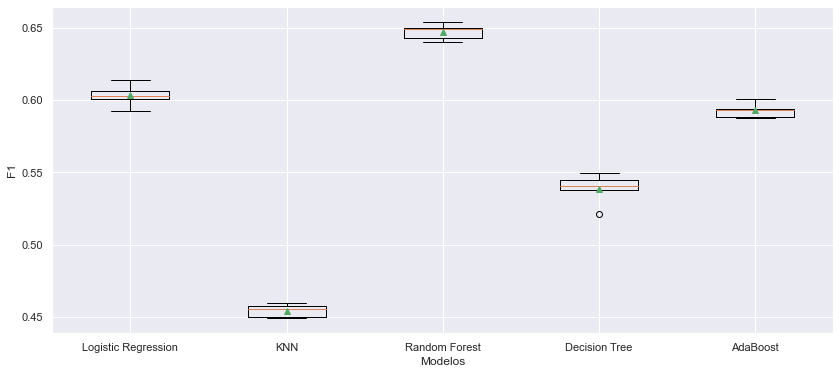

In [56]:
fig,axes = plt.subplots(1,figsize=(14,6))

labels_std = ['Logistic Regression', 'KNN']
labels_tree = ['Random Forest', 'Decision Tree', 'AdaBoost']

axes.boxplot(np.vstack((results, results_tree)).T, labels = labels_std+labels_tree, showmeans=True)

axes.set_xlabel("Modelos")
axes.set_ylabel("F1")

In [58]:
results_wdc = []
results_wdc.append({'Modelos_std': np.mean(results, axis=1), 'Modelos_tree': np.mean(results_tree, axis=1)})

In [60]:
results_total = results_wdc[0]

clusters = {'Agglomerative + Features Temporales(1)':results_total}

for cluster in clusters.keys():
    print("{} - Media de F1 para Regresión Logística: {:.6f}".format(cluster, clusters[cluster]['Modelos_std'][0]))
    print("{} - Media de F1 para KNN: {:.6f}".format(cluster, clusters[cluster]['Modelos_std'][1]))
    print("{} - Media de F1 para Random Forest: {:.6f}".format(cluster, clusters[cluster]['Modelos_tree'][0]))
    print("{} - Media de F1 para Decision Tree: {:.6f}".format(cluster, clusters[cluster]['Modelos_tree'][1]))
    print("{} - Media de F1 para AdaBoost: {:.6f}".format(cluster, clusters[cluster]['Modelos_tree'][2]))

Agglomerative + Features Temporales(1) - Media de F1 para Regresión Logística: 0.603245
Agglomerative + Features Temporales(1) - Media de F1 para KNN: 0.454400
Agglomerative + Features Temporales(1) - Media de F1 para Random Forest: 0.647095
Agglomerative + Features Temporales(1) - Media de F1 para Decision Tree: 0.538831
Agglomerative + Features Temporales(1) - Media de F1 para AdaBoost: 0.592848


Se observa como para ésta estrategia de imputación de valores faltantes de la dirección del viento, se deteriora significativamente el rendimiento de los modelos de KNN y árboles de decisión. El resto de los modelos muestran un desempeño similar.

#### Dataset (3): Eliminación de Muestras

In [62]:
features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Day', 'RainToday_enc', 'WGD_deg_sin',
       'WGD_deg_cos', 'WD9_deg_sin', 'WD9_deg_cos', 'WD3_deg_sin',
       'WD3_deg_cos', '2007.0', '2010.0', '2011.0',
       '2012.0', '2015.0', '2016.0', 'Day_sin', 'Day_cos', 'Island', 'dist2coast',
        'Cluster_ac_0', 'Cluster_ac_1', 'Cluster_ac_2',
       'Cluster_ac_3', 'Cluster_ac_4', 'Cluster_ac_5', 'Cluster_ac_6']

In [63]:
results=[]
results_tree = []

results = kfold_model_evaluation(X_train_wdn[features], y_train_wdn, modelos_std, "std", 'f1')
results_tree = kfold_model_evaluation(X_train_wdn[features], y_train_wdn, modelos_tree, None, 'f1')

Finalizado modelo: LogisticRegression(max_iter=1000)
Finalizado modelo: KNeighborsClassifier(n_neighbors=3)
Finalizado modelo: RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=0)
Finalizado modelo: DecisionTreeClassifier(max_depth=16, max_features='sqrt')
Finalizado modelo: AdaBoostClassifier()


Text(0, 0.5, 'F1')

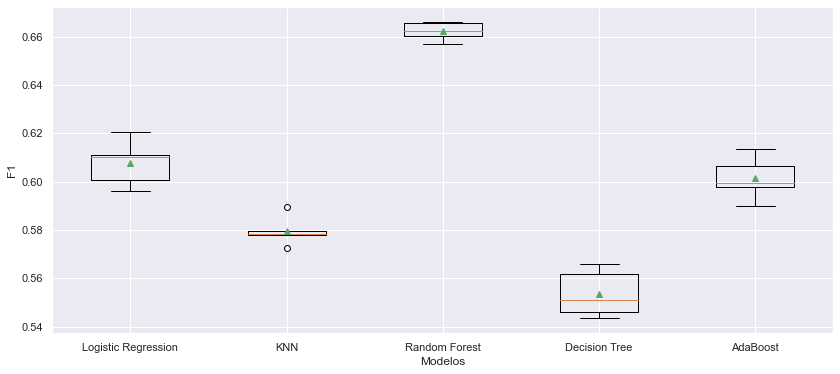

In [64]:
fig,axes = plt.subplots(1,figsize=(14,6))

labels_std = ['Logistic Regression', 'KNN']
labels_tree = ['Random Forest', 'Decision Tree', 'AdaBoost']

axes.boxplot(np.vstack((results, results_tree)).T, labels = labels_std+labels_tree, showmeans=True)

axes.set_xlabel("Modelos")
axes.set_ylabel("F1")

In [65]:
results_wdn = []
results_wdn.append({'Modelos_std': np.mean(results, axis=1), 'Modelos_tree': np.mean(results_tree, axis=1)})

In [66]:
results_total = results_wdn[0]

clusters = {'Agglomerative + Features Temporales(2)':results_total}

for cluster in clusters.keys():
    print("{} - Media de F1 para Regresión Logística: {:.6f}".format(cluster, clusters[cluster]['Modelos_std'][0]))
    print("{} - Media de F1 para KNN: {:.6f}".format(cluster, clusters[cluster]['Modelos_std'][1]))
    print("{} - Media de F1 para Random Forest: {:.6f}".format(cluster, clusters[cluster]['Modelos_tree'][0]))
    print("{} - Media de F1 para Decision Tree: {:.6f}".format(cluster, clusters[cluster]['Modelos_tree'][1]))
    print("{} - Media de F1 para AdaBoost: {:.6f}".format(cluster, clusters[cluster]['Modelos_tree'][2]))

Agglomerative + Features Temporales(2) - Media de F1 para Regresión Logística: 0.607605
Agglomerative + Features Temporales(2) - Media de F1 para KNN: 0.579439
Agglomerative + Features Temporales(2) - Media de F1 para Random Forest: 0.662210
Agglomerative + Features Temporales(2) - Media de F1 para Decision Tree: 0.553723
Agglomerative + Features Temporales(2) - Media de F1 para AdaBoost: 0.601442


Llamativamente, el dataset donde se eliminaron los valores faltantes de dirección del viento, es el que mejor resultados presenta para la mayoría de los modelos. Es notable la mejoría en Random Forest y en AdaBoost.

### Dataset balanceado

A continuación, vamos a utilizar SMOTE para balancear el dataset. Nuevamente, no es el objetivo del trabajo realizar un ajuste fino de los parámetros de SMOTE.

In [89]:
def kfold_model_evaluation_smote(X_train, y_train, models, info, metric):
    results = []
    

    
    for model in models:
        if info=="std":
            pipeline =  imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                             ['scaler', StandardScaler()],
                                             ['model', model]])
        else:
            pipeline =  imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                             ['model', model]])
            
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
        scores = cross_val_score(pipeline, X_train, y_train, scoring = metric , cv=cv, n_jobs=-1)    
        results.append(scores)
        print("Finalizado modelo: {}".format(model))
    return results

#### Dataset (1)

In [90]:
features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Day', 'RainToday_enc', 'WGD_deg_sin',
       'WGD_deg_cos', 'WD9_deg_sin', 'WD9_deg_cos', 'WD3_deg_sin',
       'WD3_deg_cos', '2007.0', '2010.0', '2011.0',
       '2012.0', '2015.0', '2016.0', 'Day_sin', 'Day_cos', 'Island', 'dist2coast',
        'Cluster_ac_0', 'Cluster_ac_1', 'Cluster_ac_2',
       'Cluster_ac_3', 'Cluster_ac_4', 'Cluster_ac_5', 'Cluster_ac_6']

In [91]:
results=[]
results_tree = []

results = kfold_model_evaluation_smote(X_train_wdm[features], y_train, modelos_std, "std", 'f1')
results_tree = kfold_model_evaluation_smote(X_train_wdm[features], y_train, modelos_tree, None, 'f1')

Finalizado modelo: LogisticRegression(max_iter=1000)
Finalizado modelo: KNeighborsClassifier(n_neighbors=3)
Finalizado modelo: RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=0)
Finalizado modelo: DecisionTreeClassifier(max_depth=16, max_features='sqrt')
Finalizado modelo: AdaBoostClassifier()


Text(0, 0.5, 'F1')

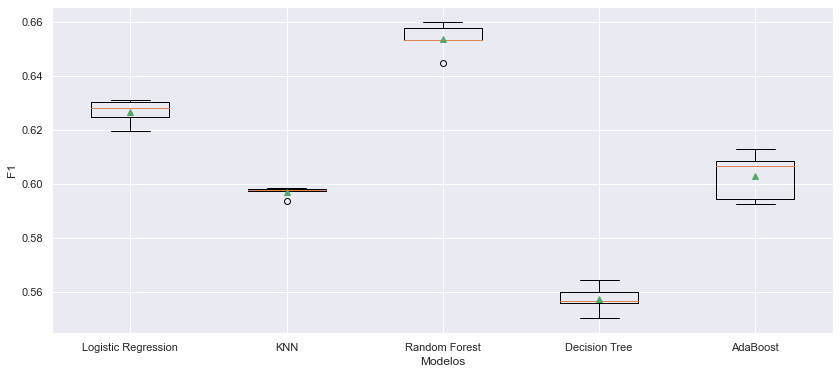

In [93]:
fig,axes = plt.subplots(1,figsize=(14,6))

labels_std = ['Logistic Regression', 'KNN']
labels_tree = ['Random Forest', 'Decision Tree', 'AdaBoost']

axes.boxplot(np.vstack((results, results_tree)).T, labels = labels_std+labels_tree, showmeans=True)

axes.set_xlabel("Modelos")
axes.set_ylabel("F1")

In [94]:
results_wdm.append({'Modelos_std': np.mean(results, axis=1), 'Modelos_tree': np.mean(results_tree, axis=1)})

In [95]:
results_total = results_wdm[-1]

clusters = {'Agglomerative + Features Temporales Balanceado':results_total}

for cluster in clusters.keys():
    print("{} - Media de F1 para Regresión Logística: {:.6f}".format(cluster, clusters[cluster]['Modelos_std'][0]))
    print("{} - Media de F1 para KNN: {:.6f}".format(cluster, clusters[cluster]['Modelos_std'][1]))
    print("{} - Media de F1 para Random Forest: {:.6f}".format(cluster, clusters[cluster]['Modelos_tree'][0]))
    print("{} - Media de F1 para Decision Tree: {:.6f}".format(cluster, clusters[cluster]['Modelos_tree'][1]))
    print("{} - Media de F1 para AdaBoost: {:.6f}".format(cluster, clusters[cluster]['Modelos_tree'][2]))

Agglomerative + Features Temporales Balanceado - Media de F1 para Regresión Logística: 0.626784
Agglomerative + Features Temporales Balanceado - Media de F1 para KNN: 0.597121
Agglomerative + Features Temporales Balanceado - Media de F1 para Random Forest: 0.653825
Agglomerative + Features Temporales Balanceado - Media de F1 para Decision Tree: 0.557449
Agglomerative + Features Temporales Balanceado - Media de F1 para AdaBoost: 0.603059


Es notable como al balancear el dataset mejoran sustancialmente los modelos de regresión logística y KNN, sobre todo éste último. No se observan grandes variaciones para los modelos basados en árboles o ensamblados.

#### Dataset (2)

In [96]:
features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Day', 'RainToday_enc', 'WGD_E', 'WGD_ENE',
       'WGD_ESE', 'WGD_Missing', 'WGD_N', 'WGD_NE', 'WGD_NNE', 'WGD_NNW',
       'WGD_NW', 'WGD_S', 'WGD_SE', 'WGD_SSE', 'WGD_SSW', 'WGD_SW', 'WGD_W',
       'WGD_WNW', 'WGD_WSW', 'WD9_E', 'WD9_ENE', 'WD9_ESE', 'WD9_Missing',
       'WD9_N', 'WD9_NE', 'WD9_NNE', 'WD9_NNW', 'WD9_NW', 'WD9_S', 'WD9_SE',
       'WD9_SSE', 'WD9_SSW', 'WD9_SW', 'WD9_W', 'WD9_WNW', 'WD9_WSW', 'WD3_E',
       'WD3_ENE', 'WD3_ESE', 'WD3_Missing', 'WD3_N', 'WD3_NE', 'WD3_NNE',
       'WD3_NNW', 'WD3_NW', 'WD3_S', 'WD3_SE', 'WD3_SSE', 'WD3_SSW', 'WD3_SW',
       'WD3_W', 'WD3_WNW', 'WD3_WSW', '2007.0', '2010.0', '2011.0',
       '2012.0', '2015.0', '2016.0', 'Day_sin', 'Day_cos', 'Island', 'dist2coast',
        'Cluster_ac_0', 'Cluster_ac_1', 'Cluster_ac_2',
       'Cluster_ac_3', 'Cluster_ac_4', 'Cluster_ac_5', 'Cluster_ac_6']

In [97]:
results=[]
results_tree = []

results = kfold_model_evaluation_smote(X_train_wdc[features], y_train, modelos_std, "std", 'f1')
results_tree = kfold_model_evaluation_smote(X_train_wdc[features], y_train, modelos_tree, None, 'f1')

Finalizado modelo: LogisticRegression(max_iter=1000)
Finalizado modelo: KNeighborsClassifier(n_neighbors=3)
Finalizado modelo: RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=0)
Finalizado modelo: DecisionTreeClassifier(max_depth=16, max_features='sqrt')
Finalizado modelo: AdaBoostClassifier()


Text(0, 0.5, 'F1')

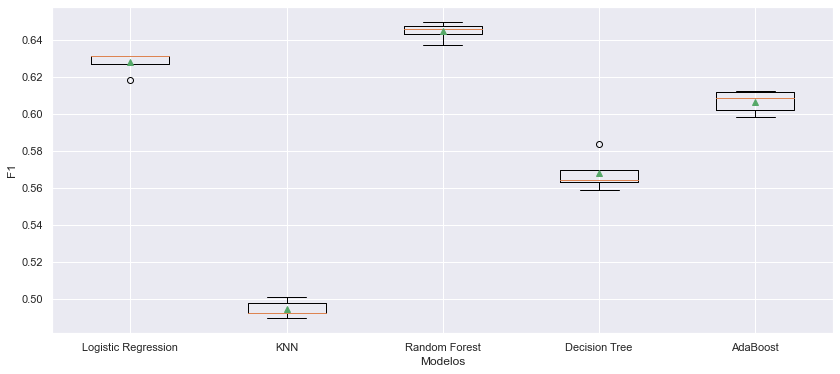

In [98]:
fig,axes = plt.subplots(1,figsize=(14,6))

labels_std = ['Logistic Regression', 'KNN']
labels_tree = ['Random Forest', 'Decision Tree', 'AdaBoost']

axes.boxplot(np.vstack((results, results_tree)).T, labels = labels_std+labels_tree, showmeans=True)

axes.set_xlabel("Modelos")
axes.set_ylabel("F1")

In [99]:
results_wdc.append({'Modelos_std': np.mean(results, axis=1), 'Modelos_tree': np.mean(results_tree, axis=1)})

results_total = results_wdc[-1]

clusters = {'Agglomerative + Features Temporales Balanceado':results_total}

for cluster in clusters.keys():
    print("{} - Media de F1 para Regresión Logística: {:.6f}".format(cluster, clusters[cluster]['Modelos_std'][0]))
    print("{} - Media de F1 para KNN: {:.6f}".format(cluster, clusters[cluster]['Modelos_std'][1]))
    print("{} - Media de F1 para Random Forest: {:.6f}".format(cluster, clusters[cluster]['Modelos_tree'][0]))
    print("{} - Media de F1 para Decision Tree: {:.6f}".format(cluster, clusters[cluster]['Modelos_tree'][1]))
    print("{} - Media de F1 para AdaBoost: {:.6f}".format(cluster, clusters[cluster]['Modelos_tree'][2]))

Agglomerative + Features Temporales Balanceado - Media de F1 para Regresión Logística: 0.627708
Agglomerative + Features Temporales Balanceado - Media de F1 para KNN: 0.494797
Agglomerative + Features Temporales Balanceado - Media de F1 para Random Forest: 0.644535
Agglomerative + Features Temporales Balanceado - Media de F1 para Decision Tree: 0.568037
Agglomerative + Features Temporales Balanceado - Media de F1 para AdaBoost: 0.606557


Nuevamente, en éste caso se evidencia una mejora en el modelo de regresión logística pero empeora sustancialmente el modelo de vecinos cercanos.

#### Dataset (3)

In [100]:
features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Day', 'RainToday_enc', 'WGD_deg_sin',
       'WGD_deg_cos', 'WD9_deg_sin', 'WD9_deg_cos', 'WD3_deg_sin',
       'WD3_deg_cos', '2007.0', '2010.0', '2011.0',
       '2012.0', '2015.0', '2016.0', 'Day_sin', 'Day_cos', 'Island', 'dist2coast',
        'Cluster_ac_0', 'Cluster_ac_1', 'Cluster_ac_2',
       'Cluster_ac_3', 'Cluster_ac_4', 'Cluster_ac_5', 'Cluster_ac_6']

In [101]:
results=[]
results_tree = []

results = kfold_model_evaluation_smote(X_train_wdn[features], y_train_wdn, modelos_std, "std", 'f1')
results_tree = kfold_model_evaluation_smote(X_train_wdn[features], y_train_wdn, modelos_tree, None, 'f1')

Finalizado modelo: LogisticRegression(max_iter=1000)
Finalizado modelo: KNeighborsClassifier(n_neighbors=3)
Finalizado modelo: RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=0)
Finalizado modelo: DecisionTreeClassifier(max_depth=16, max_features='sqrt')
Finalizado modelo: AdaBoostClassifier()


Text(0, 0.5, 'F1')

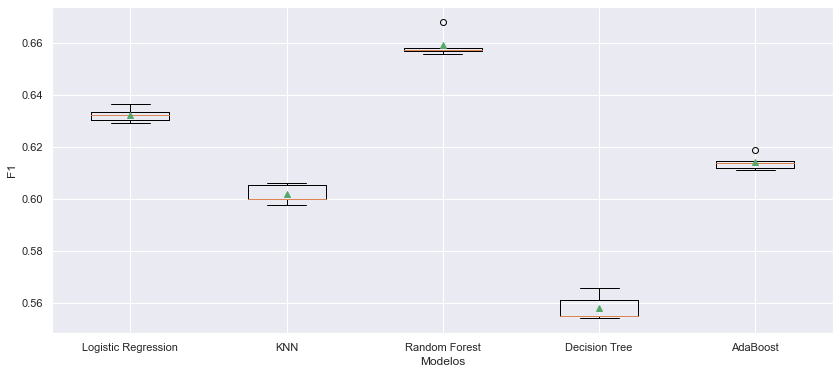

In [102]:
fig,axes = plt.subplots(1,figsize=(14,6))

labels_std = ['Logistic Regression', 'KNN']
labels_tree = ['Random Forest', 'Decision Tree', 'AdaBoost']

axes.boxplot(np.vstack((results, results_tree)).T, labels = labels_std+labels_tree, showmeans=True)

axes.set_xlabel("Modelos")
axes.set_ylabel("F1")

In [103]:
results_wdn.append({'Modelos_std': np.mean(results, axis=1), 'Modelos_tree': np.mean(results_tree, axis=1)})

results_total = results_wdn[-1]

clusters = {'Agglomerative + Features Temporales Balanceado':results_total}

for cluster in clusters.keys():
    print("{} - Media de F1 para Regresión Logística: {:.6f}".format(cluster, clusters[cluster]['Modelos_std'][0]))
    print("{} - Media de F1 para KNN: {:.6f}".format(cluster, clusters[cluster]['Modelos_std'][1]))
    print("{} - Media de F1 para Random Forest: {:.6f}".format(cluster, clusters[cluster]['Modelos_tree'][0]))
    print("{} - Media de F1 para Decision Tree: {:.6f}".format(cluster, clusters[cluster]['Modelos_tree'][1]))
    print("{} - Media de F1 para AdaBoost: {:.6f}".format(cluster, clusters[cluster]['Modelos_tree'][2]))

Agglomerative + Features Temporales Balanceado - Media de F1 para Regresión Logística: 0.632290
Agglomerative + Features Temporales Balanceado - Media de F1 para KNN: 0.601781
Agglomerative + Features Temporales Balanceado - Media de F1 para Random Forest: 0.659099
Agglomerative + Features Temporales Balanceado - Media de F1 para Decision Tree: 0.558106
Agglomerative + Features Temporales Balanceado - Media de F1 para AdaBoost: 0.613983


Al igual que ocurrió con el dataset sin balancear, se tienen los mejores resultados entre las tres técnicas de tratamiento de valores faltantes. El hecho de haber balanceado el dataset impactó significativamente en la mejora del score para Regresión Logística, Random Forest y AdaBoost. Se utilizará por lo tanto éste dataset para evaluar el dataset de validación.

## Evaluación de Resultados

A continuación, vamos a evaluar los resultados para los modelos elegidos sobre el dataset de validación. Para ello, se utilizarán los imputers, scalers y encoders de la sección anterior.

In [108]:
X_test = pd.read_csv("X_test.csv")

with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

In [109]:
X_test.shape, y_test.shape

((28439, 28), (28439,))

In [111]:
type(y_test)

pandas.core.series.Series

In [110]:
X_test.isna().sum()

Date                 0
Location             0
MinTemp            124
MaxTemp             64
Rainfall           275
Evaporation      12148
Sunshine         13472
WindGustDir       1845
WindGustSpeed     1830
WindDir9am        1958
WindDir3pm         712
WindSpeed9am       266
WindSpeed3pm       500
Humidity9am        356
Humidity3pm        713
Pressure9am       2727
Pressure3pm       2719
Cloud9am         10780
Cloud3pm         11425
Temp9am            169
Temp3pm            523
RainToday          275
Latitude             0
Longitude            0
Day                  0
Month                0
Year                 0
RainToday_enc        0
dtype: int64

#### Eliminamos NaNs de RainToday

In [112]:
idx_rt_nan = X_test['RainToday'].isna()==False

In [113]:
idx_rt_nan[:5]

0    True
1    True
2    True
3    True
4    True
Name: RainToday, dtype: bool

In [115]:
y_test = np.array(y_test)[idx_rt_nan]

In [117]:
X_test.dropna(subset=['RainToday'], inplace=True)

In [118]:
X_test.shape, y_test.shape

((28164, 28), (28164,))

#### Eliminamos Nans de las Direcciones del Viento

In [119]:
mask_windir_nan = (X_test['WindDir9am'].isna()==False) & (X_test['WindDir3pm'].isna()==False) & (X_test['WindGustDir'].isna()==False) 

X_test = X_test.loc[mask_windir_nan].copy()

y_test = y_test[mask_windir_nan]

In [120]:
X_test.shape, y_test.shape

((24809, 28), (24809,))

In [122]:
imputers

{'imputer_wdm': SimpleImputer(strategy='most_frequent'),
 'imputer_mice': IterativeImputer(max_value=None, min_value=None)}

In [123]:
encoders

{'y_encoder': LabelEncoder(),
 'year_encoder': OneHotEncoder(sparse=False),
 'month_slot_ohe': OneHotEncoder(sparse=False),
 'month_ohe': array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'wind_encoder': OneHotEncoder(sparse=False),
 'wind_names': array(['WGD_E', 'WGD_ENE', 'WGD_ESE', 'WGD_Missing', 'WGD_N', 'WGD_NE',
        'WGD_NNE', 'WGD_NNW', 'WGD_NW', 'WGD_S', 'WGD_SE', 'WGD_SSE',
        'WGD_SSW', 'WGD_SW', 'WGD_W', 'WGD_WNW', 'WGD_WSW', 'WD9_E',
        'WD9_ENE', 'WD9_ESE', 'WD9_Missing', 'WD9_N', 'WD9_NE', 'WD9_NNE',
        'WD9_NNW', 'WD9_NW', 'WD9_S', 'WD9_SE', 'WD9_SSE', 'WD9_SSW',
        'WD9_SW', 'WD9_W', 'WD9_WNW', 'WD9_WSW', 'WD3_E', 'WD3_ENE',
        'WD3_ESE', 'WD3_Missing', 'WD3_N', 'WD3_NE', 'WD3_NNE', 'WD3_NNW',
        'WD3_NW', 'WD3_S', 'WD3_SE', 'WD3_SSE', 'WD3_

In [129]:
scalers

{'scaler_imputer': StandardScaler()}

#### Codificación variable de salida

In [124]:
y_test = encoders['y_encoder'].transform(y_test)

In [125]:
y_test[:2]

array([0, 1])

#### Codificación RainToday

In [126]:
X_test['RainToday_enc'] = X_test['RainToday'].apply(lambda x: 1 if x == 'Yes' else 0 if x == 'No' else -1)

#### Procesamiento Fecha

In [127]:
X_test['Date'] = pd.to_datetime(X_test['Date'])
X_test['Day'] = X_test['Date'].dt.day
X_test['Month'] = X_test['Date'].dt.month
X_test['Year'] = X_test['Date'].dt.year

#### Imputación por MICE

In [128]:
# Features a utilizar en MICE

cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday_enc', 'Day', 'Month', 'Year']

In [131]:
x_test_imputer = pd.DataFrame(scalers['scaler_imputer'].transform(X_test[cols]), columns = X_test[cols].columns)

In [132]:
x_test_imputer.head(2)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday_enc,Day,Month,Year
0,0.457071,1.358919,-0.276301,NaN,NaN,0.741644,-0.786872,-0.867725,0.219057,-0.935451,-0.304128,-0.492020,0.890769,NaN,0.311131,1.241186,-0.536001,1.168904,-1.580134,1.666777
1,-0.588462,-0.987109,-0.276301,-0.353342,-1.40822,0.446693,1.583468,1.065316,-1.249633,1.082259,-0.895219,-0.477808,0.890769,0.919227,-0.503877,-1.020151,-0.536001,-0.421961,0.757374,-0.298756


In [133]:
cols_imputed = imputers['imputer_mice'].transform(x_test_imputer)

In [134]:
x_test_imputer[cols] = cols_imputed
x_test_imputer.isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday_enc    0
Day              0
Month            0
Year             0
dtype: int64

In [135]:
x_test_imputer = scalers['scaler_imputer'].inverse_transform(x_test_imputer)

In [136]:
X_test.loc[:, cols] = x_test_imputer

In [137]:
X_test.head(1)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Cloud3pm,Temp9am,Temp3pm,RainToday,Latitude,Longitude,Day,Month,Year,RainToday_enc
0,2017-01-26,Canberra,15.1,32.9,0.0,8.121207,6.69165,E,50.0,E,...,5.447002,19.0,30.3,No,-35.297591,149.101268,26.0,1.0,2017.0,0.0


In [138]:
X_test.isna().sum().sum()

0

#### Codificaciones

##### Año

In [139]:
def add_features(df_orig, data, columns):    
    df_orig = pd.concat(
        [
            df_orig,
            pd.DataFrame(
                data, 
                index=df_orig.index, 
                columns=columns
            )
        ], axis=1
    )
    return df_orig

In [140]:
years_encoded = encoders['year_encoder'].transform(X_test['Year'].values.reshape(-1, 1))
cat_names = np.array(encoders['year_encoder'].categories_).ravel()

In [141]:
X_test = add_features(X_test, years_encoded, cat_names)

In [148]:
X_test[2008.].head(2)

0    0.0
1    0.0
Name: 2008.0, dtype: float64

##### Día y Mes

In [151]:
X_test['DoY'] = X_test['Date'].apply(lambda x: pd.Period(x, 'h').dayofyear)

day_sin = np.sin((X_test['DoY'] -1) * (2. * np.pi / 365))
day_cos = np.cos((X_test['DoY'] -1) * (2. * np.pi / 365))

cols = ['Day_sin', 'Day_cos']
X_test = add_features(X_test, np.vstack((day_sin, day_cos)).T, cols)

In [152]:
X_test['Day_sin'].min(), X_test['Day_sin'].max()

(-0.9999907397361901, 0.9999907397361901)

##### Dirección del Viento

In [153]:
wind_dict = encoders['wind_deg']

In [154]:
cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
abb = {'WindGustDir':'WGD', 'WindDir9am':'WD9', 'WindDir3pm':'WD3'}

for col in cols: 
    mask = X_test[col].isna()==False
    colname = abb[col] + "_" + "deg"
    sin_colname = colname + "_sin"
    cos_colname = colname + "_cos"
    
    wind_data = X_test.loc[mask, col].apply(lambda x: wind_dict[x]) 
    wind_sin = np.sin((wind_data - 22.5) * (2. * np.pi / 360))
    wind_cos = np.cos((wind_data - 22.5) * (2. * np.pi / 360))
    
    X_test.loc[mask, sin_colname] = wind_sin
    X_test.loc[mask, cos_colname] = wind_cos

##### Ubicación

In [156]:
X_test['Island'] = X_test['Location'].apply(lambda x: encoders['loc_island'].setdefault(x, 0))

In [157]:
X_test['dist2coast'] = X_test['Location'].apply(lambda x: encoders['loc_distc'][x])

In [158]:
X_test['Cluster_ac'] = X_test['Location'].apply(lambda x: clusters['agg'][x])

In [159]:
ac_encoded = encoders['loc_clust_ac'].transform(X_test['Cluster_ac'].values.reshape(-1, 1))
ac_names = encoders['loc_clust_ac'].get_feature_names(['Cluster_ac'])
X_test = add_features(X_test, ac_encoded, ac_names)

#### Verificamos el Dataset Final

In [160]:
X_test.shape, y_test.shape

((24809, 58), (24809,))

In [161]:
X_test.isna().sum().sum()

0

### Evaluación

In [162]:
from sklearn.tree import export_graphviz 
from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix

In [179]:
features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Day', 'RainToday_enc', 'WGD_deg_sin',
       'WGD_deg_cos', 'WD9_deg_sin', 'WD9_deg_cos', 'WD3_deg_sin',
       'WD3_deg_cos', 2007.0, 2010.0, 2011.0,
       2012.0, 2015.0, 2016.0, 'Day_sin', 'Day_cos', 'Island', 'dist2coast',
        'Cluster_ac_0', 'Cluster_ac_1', 'Cluster_ac_2',
       'Cluster_ac_3', 'Cluster_ac_4', 'Cluster_ac_5', 'Cluster_ac_6']

#### Regresión Logística

In [164]:
# Regresión Logística

model = LogisticRegression(max_iter=1000)

pipeline =  imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                 ['scaler', StandardScaler()],
                                 ['model', model]])

In [165]:
pipeline.fit(X_train_wdn[features], y_train_wdn)

Pipeline(steps=[('smote', SMOTE(random_state=11)), ('scaler', StandardScaler()),
                ['model', LogisticRegression(max_iter=1000)]])

In [169]:
lr_predict = pipeline.predict(X_test[features])

              precision    recall  f1-score   support

           0       0.93      0.81      0.87     19307
           1       0.54      0.78      0.64      5502

    accuracy                           0.80     24809
   macro avg       0.73      0.80      0.75     24809
weighted avg       0.84      0.80      0.82     24809

Sensitivity :  0.9295405855748631
Specificity :  0.5394128669581512
AUC Regresión Logística:  0.7969192592392185
Recall Regresión Logística:  0.7848055252635405


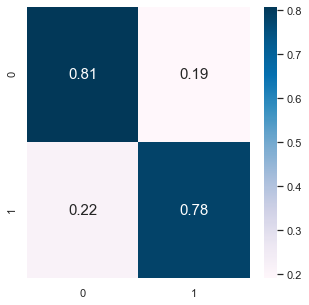

In [175]:
from sklearn.metrics import recall_score


# Confussion Matrix

cm = confusion_matrix(y_test, lr_predict)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], annot = True, annot_kws = {'size':15}, cmap = 'PuBu')

# classification report
cr = classification_report(y_test, lr_predict)
print(cr)

# Sensitivity y Specificity
sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )
specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', specificity)

fpr, tpr, thresholds = roc_curve(y_test, lr_predict)
print('AUC Regresión Logística: ', auc(fpr, tpr))

lr_recall = recall_score(y_test, lr_predict, average='binary')
print("Recall Regresión Logística: ", lr_recall)

#### Random Forest

In [177]:
model = RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=0)

pipeline =  imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                 ['model', model]])

In [178]:
pipeline.fit(X_train_wdn[features], y_train_wdn)

Pipeline(steps=[('smote', SMOTE(random_state=11)),
                ['model',
                 RandomForestClassifier(class_weight='balanced', max_depth=12,
                                        random_state=0)]])

In [180]:
rf_predict = pipeline.predict(X_test[features])

              precision    recall  f1-score   support

           0       0.91      0.89      0.90     19307
           1       0.64      0.70      0.67      5502

    accuracy                           0.84     24809
   macro avg       0.77      0.79      0.78     24809
weighted avg       0.85      0.84      0.85     24809

Sensitivity :  0.9111915663933553
Specificity :  0.6361373817819811
AUC Regresión Logística:  0.7916258837644785
Recall Regresión Logística:  0.6968375136314068


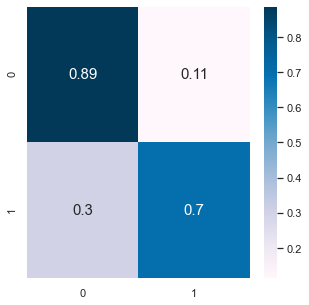

In [181]:
# Confussion Matrix

cm = confusion_matrix(y_test, rf_predict)
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], annot = True, annot_kws = {'size':15}, cmap = 'PuBu')

# classification report
cr = classification_report(y_test, rf_predict)
print(cr)

# Sensitivity y Specificity
sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )
specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', specificity)

fpr, tpr, thresholds = roc_curve(y_test, rf_predict)
print('AUC Regresión Logística: ', auc(fpr, tpr))

rf_recall = recall_score(y_test, rf_predict, average='binary')
print("Recall Regresión Logística: ", rf_recall)

Como se puede observar, se obtienen métricas similares a las obtenidas durante el ensayo de los modelos con los distintos datasets. Com era de esperar, el recall en ámbos casos es bajo, pero la precisión obtenida supera la de la clase base naive (predecir probabilidad de cada clase de acuerdo a su distribución). 